# First case: Using counts matrix as input for creating co-expression network
### The input in this case should be a tab-separated matrix with observations as columns and variables as rows. In other words, in the rows should be the entities that will be the nodes of our network. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Let's import FAVA
#### Make sure you have loaded the latest version. If you are not sure visit here: https://pypi.org/project/favapy/

In [2]:
# !pip install favapy==0.3.9.4
from favapy import fava

### Our data is a single-cell RNAseq dataset. 

In [ ]:
data = pd.read_csv("data/Example_dataset_GSE75748_sc_cell_type_ec.tsv", 
                   sep='\t') 

### Our matrix looks like this:

In [ ]:
data

### Run FAVA

In [ ]:
my_FAVAourite_network = fava.cook(data = data,
                                  log2_normalization = True, # If your data are normalized set this to False
                                  hidden_layer = None, # If None, it will be adjusted base on the input size.
                                  latent_dim = None, # If None, it will be adjusted base on the size of the hidden layer.
                                  epochs = 50, 
                                  batch_size = 32,
                                  PCC_cutoff = 0.95) # This is arbitraty. We need to plot the score distribution.
my_FAVAourite_network
    

# Second case: Using anndata as input for creating co-expression network

### If input is an AnnData object, it contains an expression matrix X, which stores n_obs observations (cells) of n_vars variables (genes).

#### Here we follow the steps as described in the scanpy tutorial here: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz


In [3]:
import scanpy as sc

adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading 

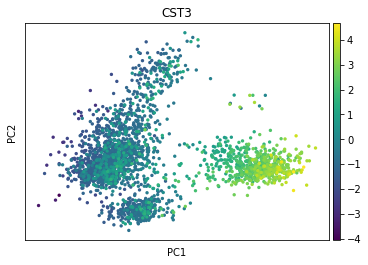

In [4]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filtering
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')


##### If the data is in Compressed Sparse Row format so we have to "uncompress" --> adata.X = adata.X.A

In [5]:
print(adata)
print(adata.X)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
[[-6.12200936e-03 -1.48024922e-03 -2.13638437e-03 ... -4.51365160e-03
  -6.40674978e-02 -3.70223857e-02]
 [-9.40247439e-03 -1.55478332e-03 -1.05254687e-02 ... -1.18392045e-02
  -1.09831728e-01 -6.34919181e-02]
 [-5.42712444e-03 -2.48085614e-03 -5.94359590e-03 ... -7.02461973e-03
  -8.56298953e-02 -5.57584986e-02]
 ...
 [-4.73570684e-03 -1.70380529e-03  7.48216098e-06 ... -2.43741483e-03
  -5.25713079e-02 -3.19451652e-02]
 [-3.90673382e-03 -1.65717863e-03  2.28009513e-03 ...  2.37765670e+00
  -4.01520319e-02 -2.45906953e-02]
 [-4.08808235e-03 -2.32962915e-03 -1.85557234e-03 ... -3.55155533e-03
  -6.32345751e-02 -4.20607105e-02]]


### Run FAVA

In [6]:
my_FAVAourite_network = fava.cook(data = adata,
                                  log2_normalization = True, # If your data are normalized set this to False
                                  hidden_layer = None, # If None, it will be adjusted base on the input size.
                                  latent_dim = None, # If None, it will be adjusted base on the size of the hidden layer.
                                  epochs = 10, 
                                  batch_size = 32,
                                  interaction_count = 5000, # How many interactions (A-B & B-A) you will have in the output file.
                                  PCC_cutoff = None # If this is specified, it overwrites the `interaction_count`.
                                 ) 
my_FAVAourite_network

Epoch 1/10
429/429 [==============================] - 18s 41ms/step - loss: 49.5736 - accuracy: 3.6459e-04 - val_loss: 32.5569 - val_accuracy: 1.4584e-04
Epoch 2/10
429/429 [==============================] - 17s 40ms/step - loss: 32.4826 - accuracy: 5.1043e-04 - val_loss: 32.3956 - val_accuracy: 0.0000e+00
Epoch 3/10
429/429 [==============================] - 17s 39ms/step - loss: 32.2335 - accuracy: 4.3751e-04 - val_loss: 32.1900 - val_accuracy: 5.8335e-04
Epoch 4/10
429/429 [==============================] - 17s 40ms/step - loss: 32.1407 - accuracy: 7.2918e-04 - val_loss: 32.1556 - val_accuracy: 6.5626e-04
Epoch 5/10
429/429 [==============================] - 17s 39ms/step - loss: 32.1056 - accuracy: 4.3751e-04 - val_loss: 32.0937 - val_accuracy: 2.9167e-04
Epoch 6/10
429/429 [==============================] - 17s 40ms/step - loss: 32.0705 - accuracy: 5.1043e-04 - val_loss: 32.0439 - val_accuracy: 0.0010
Epoch 7/10
429/429 [==============================] - 17s 40ms/step - loss: 32.0

Protein_1 Protein_2     Score
12466933     S100A8    S100A9  0.975751
12439507     S100A9    S100A8  0.975751
178307593      NKG7      CST7  0.967761
162921607      CST7      NKG7  0.967761
178299409      NKG7      GZMA  0.964404
...             ...       ...       ...
12476869     S100A8   GABARAP  0.724809
161700733    FKBP1A    TYROBP  0.724802
173809312    TYROBP    FKBP1A  0.724802
12470836     S100A8     RAB32  0.724787
65965249      RAB32    S100A8  0.724787

[5000 rows x 3 columns]

### Now we have our network! Here we remove the AB-BA interactions (keeping only AB)

In [7]:
my_FAVAourite_network_single = my_FAVAourite_network.iloc[::2, :]
my_FAVAourite_network_single


Protein_1 Protein_2     Score
12466933     S100A8    S100A9  0.975751
178307593      NKG7      CST7  0.967761
178299409      NKG7      GZMA  0.964404
59907122       LST1      AIF1  0.959885
177508056       FTL      FTH1  0.958008
...             ...       ...       ...
14453904     FCGR2A    LILRB3  0.724868
61438016     CDKN1A      FPR1  0.724859
148701811   GABARAP    S100A8  0.724809
161700733    FKBP1A    TYROBP  0.724802
12470836     S100A8     RAB32  0.724787

[2500 rows x 3 columns]

### Finding modules on the netwrok

In [8]:
import igraph as ig
import leidenalg as la
import networkx as nx

# Create a graph from the pandas DataFrame using networkx
G_nx = nx.from_pandas_edgelist(my_FAVAourite_network_single,
                               source='Protein_1',
                               target='Protein_2',
                               edge_attr='Score')

# Convert the networkx graph to igraph graph
G = ig.Graph(directed=False)
G.add_vertices(list(G_nx.nodes))
G.add_edges(list(G_nx.edges))

# Perform Leiden clustering
partition = la.find_partition(G, la.ModularityVertexPartition)

# Get the modules
modules = [frozenset(G.vs[v]['name']) for v in partition]

# Print the modules
for module in modules:
    print(module)

print(f'----')
print(f'The number of modules is: {len(modules)}')

frozenset({'C19orf59', 'GCA', 'GSTP1', 'HAUS4', 'TNFSF13B', 'RBP7', 'SAT2', 'RILPL2', 'IL1B', 'GRN', 'RNASE2', 'RNF181', 'CDKN1A', 'LGALS2', 'NFKBIA', 'MARCO', 'CD4', 'IER3', 'S100A6', 'TKT', 'PSMB3', 'CATSPER1', 'RASSF4', 'TMEM176A', 'KLF4', 'CD36', 'LYZ', 'NDUFA11', 'CDA', 'AMICA1', 'VCAN', 'TNFAIP2', 'PFDN5', 'CSF2RA', 'S100A9', 'FIBP', 'CD14', 'NUP214', 'LGALS3', 'ID1', 'LRP1', 'LINC00936', 'CEBPD', 'CSF3R', 'DHRS4L2', 'AGTRAP', 'NRG1', 'EIF3K', 'BST1', 'CTSB', 'GABARAPL1', 'ASGR1', 'ARPC1B', 'VSTM1', 'MTMR11', 'MGST1', 'CD33', 'RAB3D', 'BLVRB', 'VIM', 'MNDA', 'IL8', 'CLEC12A', 'AP1S2', 'FCGR1A', 'MT-ND1', 'MS4A6A', 'NEAT1', 'TMEM205', 'RAB32', 'SLC25A6', 'PLBD1', 'CNPY3', 'CD302', 'EIF4A1', 'TSPO', 'S100A10', 'NDUFS7', 'FOLR3', 'S100A8', 'GPX1', 'TGFBI', 'AP2S1', 'GAPDH', 'GRINA', 'QPCT', 'NUDT16', 'FCN1', 'FPR1', 'TCEB2', 'LGALS1', 'RNF130', 'ANXA2', 'S100A12', 'TALDO1', 'TMEM176B', 'CD1D', 'CSTA', 'NCF2', 'CLEC4E', 'WDR83OS', 'ALDH2'})
frozenset({'PPIA', 'KLRF1', 'CAPZB', 'CLIC3

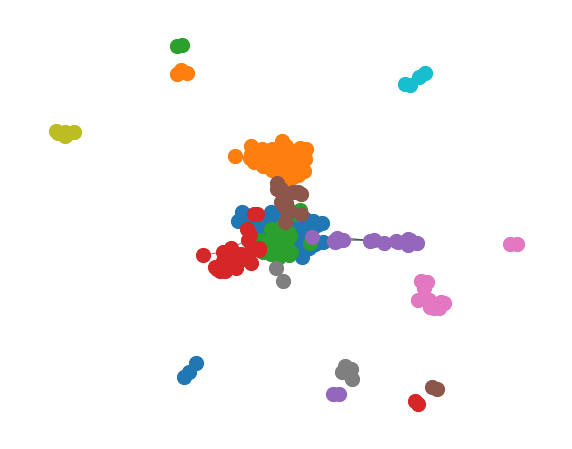

In [9]:
# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_nx)
nx.draw_networkx_nodes(G_nx, pos, node_size=200, node_color='lightgray')
nx.draw_networkx_edges(G_nx, pos, alpha=0.5)
for i, module in enumerate(modules):
    nx.draw_networkx_nodes(G_nx, pos, nodelist=list(module), node_size=200, node_color=f'C{i}')
plt.axis('off')
plt.show()


## Getting functional enrichment

Diffrently from the network API method, which retrieves only the interactions between the set of input proteins and between their closest interaction neighborhood (if add_nodes parameters is specified), interaction_partners API method provides the interactions between your set of proteins and all the other STRING proteins. 

In [10]:
import requests
import json
import matplotlib as mpl
import seaborn as sns
import textwrap

class ModulePlotter:
    def __init__(self, modules):
        self.modules = modules
        self.num_plots_per_row = 2
        self.request_url = "/".join(["https://version-11-5.string-db.org/api", "json", "enrichment"])

    def fetch_GO_list(self, module, GO_category):
        GO_list = []

        my_genes = list(module)
        params = {
            "identifiers" : "%0d".join(my_genes), # your protein
            "species" : 9606, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name
        }

        response = requests.post(self.request_url, data=params)

        data = json.loads(response.text)

        for row in data:
            term = row["term"]
            preferred_names = ",".join(row["preferredNames"])
            fdr = float(row["fdr"])
            description = row["description"]
            category = row["category"]
            if category == GO_category and fdr < 0.01: 
                GO_list.append(row)

        return GO_list

    def create_plots(self, GO_category):
        num_modules = len(self.modules)
        num_cols = self.num_plots_per_row
        num_rows = (num_modules + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12 * num_rows))

        plot_idx = 0

        for module_idx, module in enumerate(self.modules):
            GO_list = self.fetch_GO_list(module, GO_category)
            df = pd.DataFrame(GO_list)

            if not df.empty and 'p_value' in df.columns:
                df = df.sort_values(by='fdr')
                df = df.head(20)

            if not df.empty and 'p_value' in df.columns:
                row_idx = plot_idx // num_cols
                col_idx = plot_idx % num_cols

                if num_rows == 1:  # Handle 1-dimensional axes array when num_rows is 1
                    ax = axes[col_idx]
                else:
                    ax = axes[row_idx, col_idx]

                cmap = mpl.cm.bwr_r
                norm = mpl.colors.Normalize(vmin=df['p_value'].min(), vmax=df['p_value'].max())
                mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

                sns.barplot(data=df, x='number_of_genes', y='description', palette=mapper.to_rgba(df['p_value']), ax=ax)
                ax.set_yticklabels([textwrap.fill(e, 22) for e in df['description']])
                ax.set_title(f"Module {module_idx + 1}")
                ax.tick_params(axis='both', labelsize=8)

                plot_idx += 1

        for i in range(plot_idx, num_rows * num_cols):
            row_idx = i // num_cols
            col_idx = i % num_cols

            if num_rows == 1:  # Handle 1-dimensional axes array when num_rows is 1
                ax = axes[col_idx]
            else:
                ax = axes[row_idx, col_idx]

            ax.axis('off')

        plt.tight_layout()
        fig.subplots_adjust(right=1, hspace=0.2, wspace=0.5)  # Adjust the spacing between subplots

        # Find the last non-empty subplot
        last_plot_idx = plot_idx - 1

        if last_plot_idx >= 0:
            last_row_idx = last_plot_idx // num_cols
            last_col_idx = last_plot_idx % num_cols

            if num_rows == 1:  # Handle 1-dimensional axes array when num_rows is 1
                last_ax = axes[last_col_idx]
            else:
                last_ax = axes[last_row_idx, last_col_idx]

            # Remove empty subplots
            for i in range(last_plot_idx + 1, num_rows * num_cols):
                row_idx = i // num_cols
                col_idx = i % num_cols

                if num_rows == 1:  # Handle 1-dimensional axes array when num_rows is 1
                    ax = axes[col_idx]
                else:
                    ax = axes[row_idx, col_idx]

                fig.delaxes(ax)

            # Adjust the figure size based on the number of non-empty subplots
            fig.set_size_inches(12, 12 * (last_row_idx + 3))

        cax = fig.add_axes([1.1, 0.9, 0.05, 0.08])
        cbl = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')

        plt.show()

#### Category options: 
Process, 
COMPARTMENTS, 
TISSUES, 
DISEASES, 
Keyword, 
KEGG, 
SMART, 
InterPro, 
Pfam, 
PMID, 
Function, 
Component, 
RCTM, 
WikiPathways, 
HPO, 
NetworkNeighborAL

GO Process:


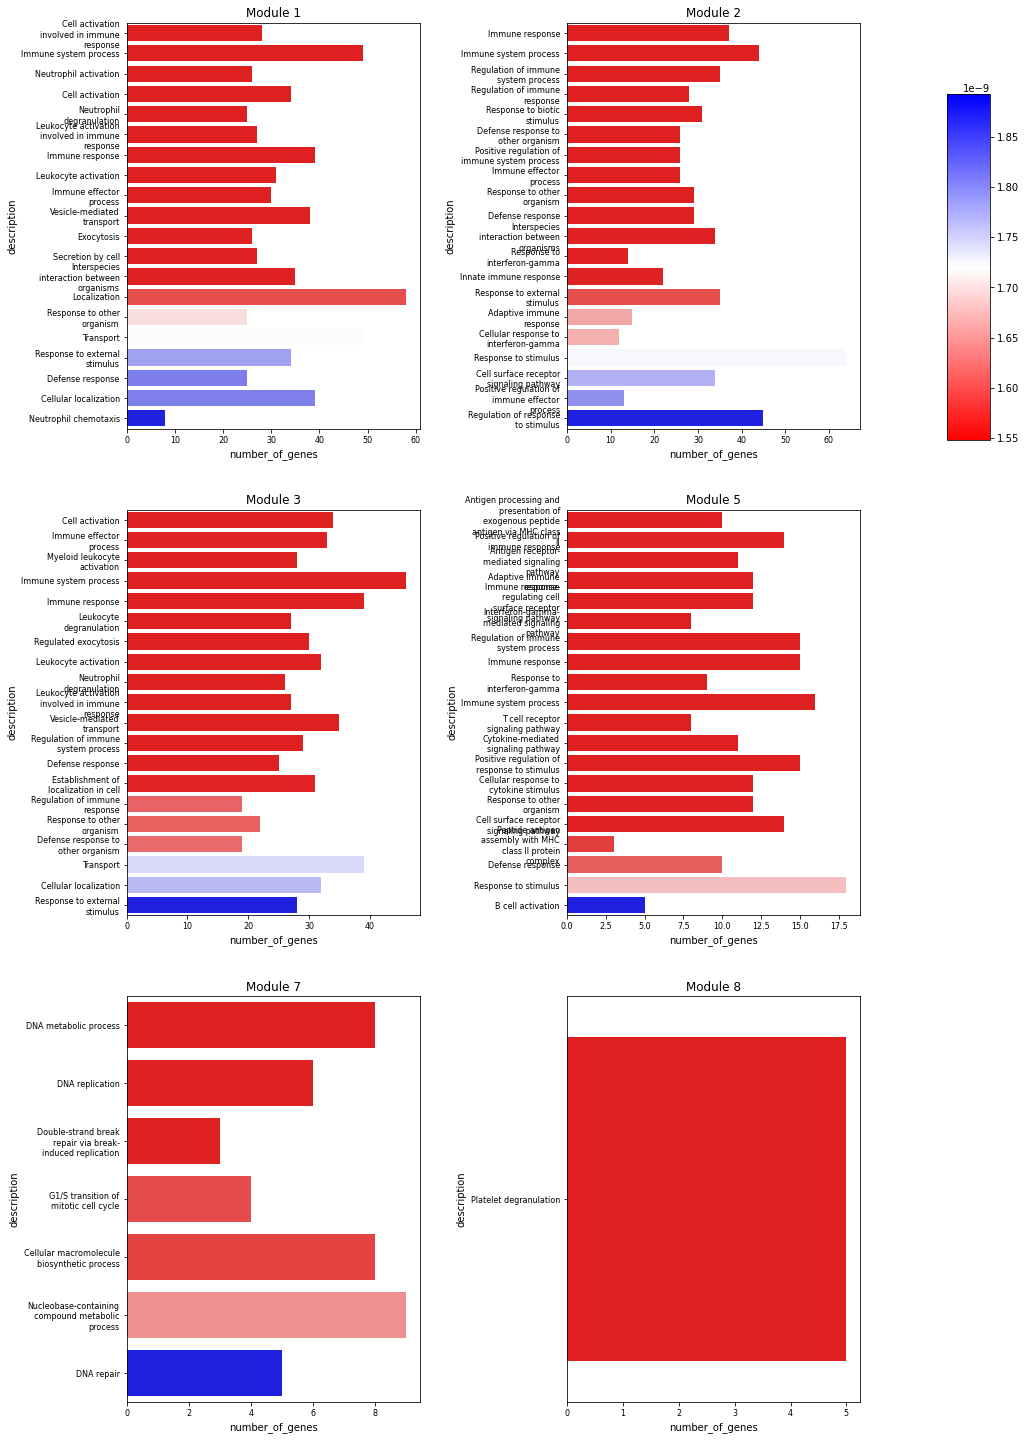

GO Function:


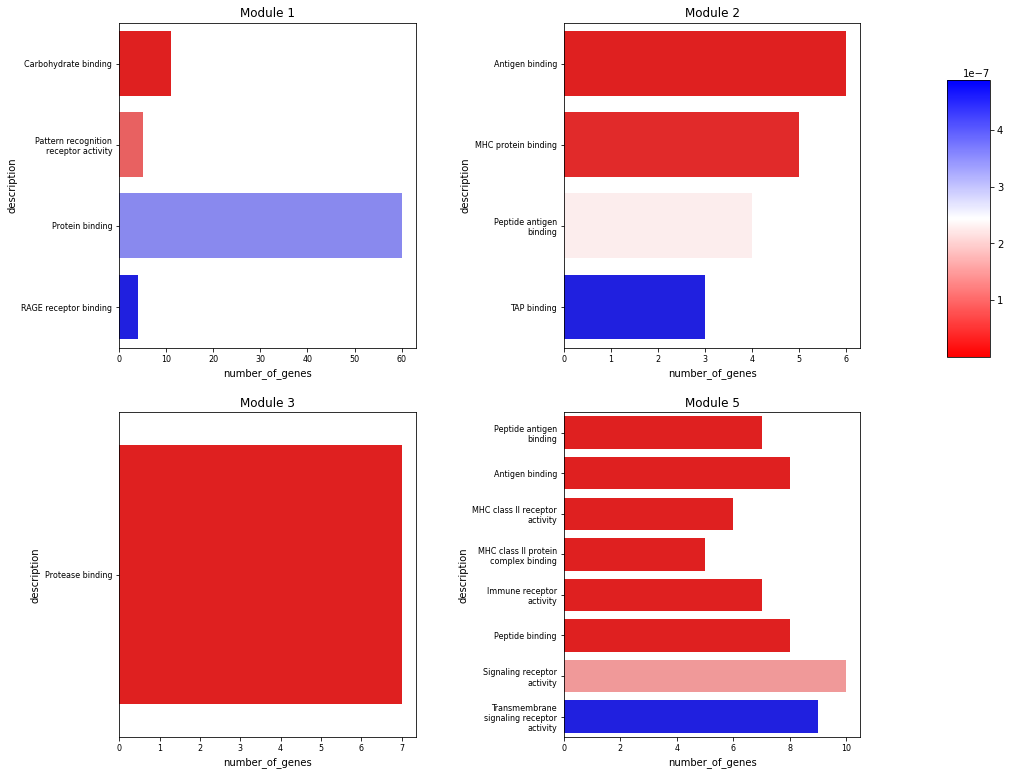

Diseases:


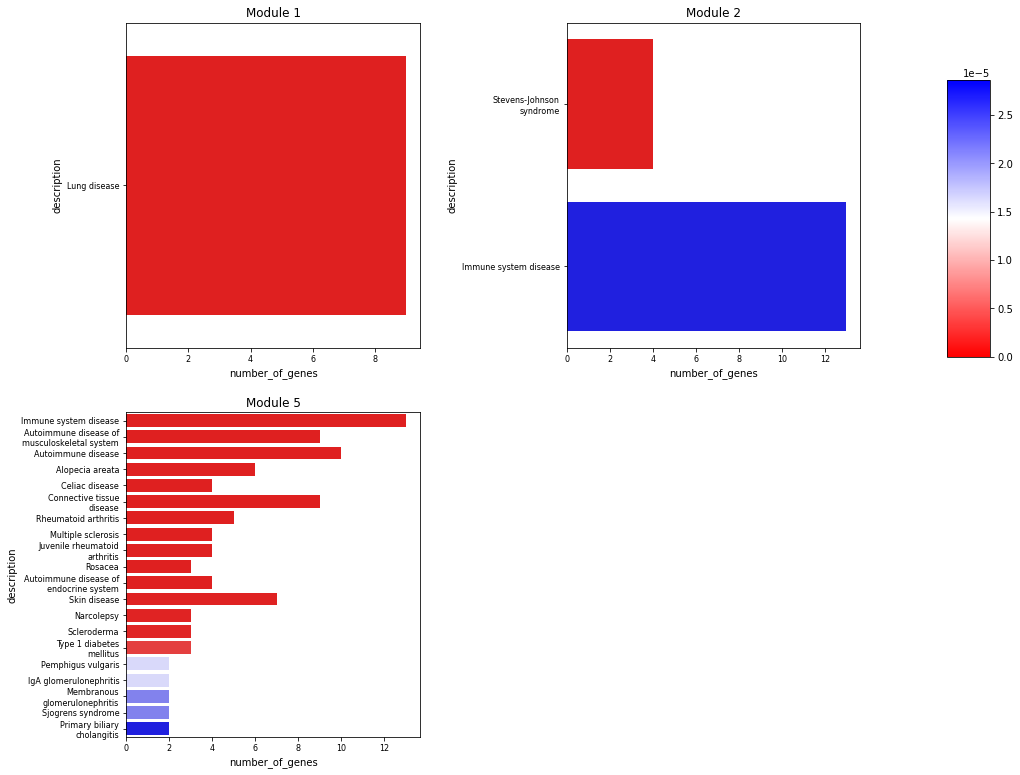

KEGG pathways:


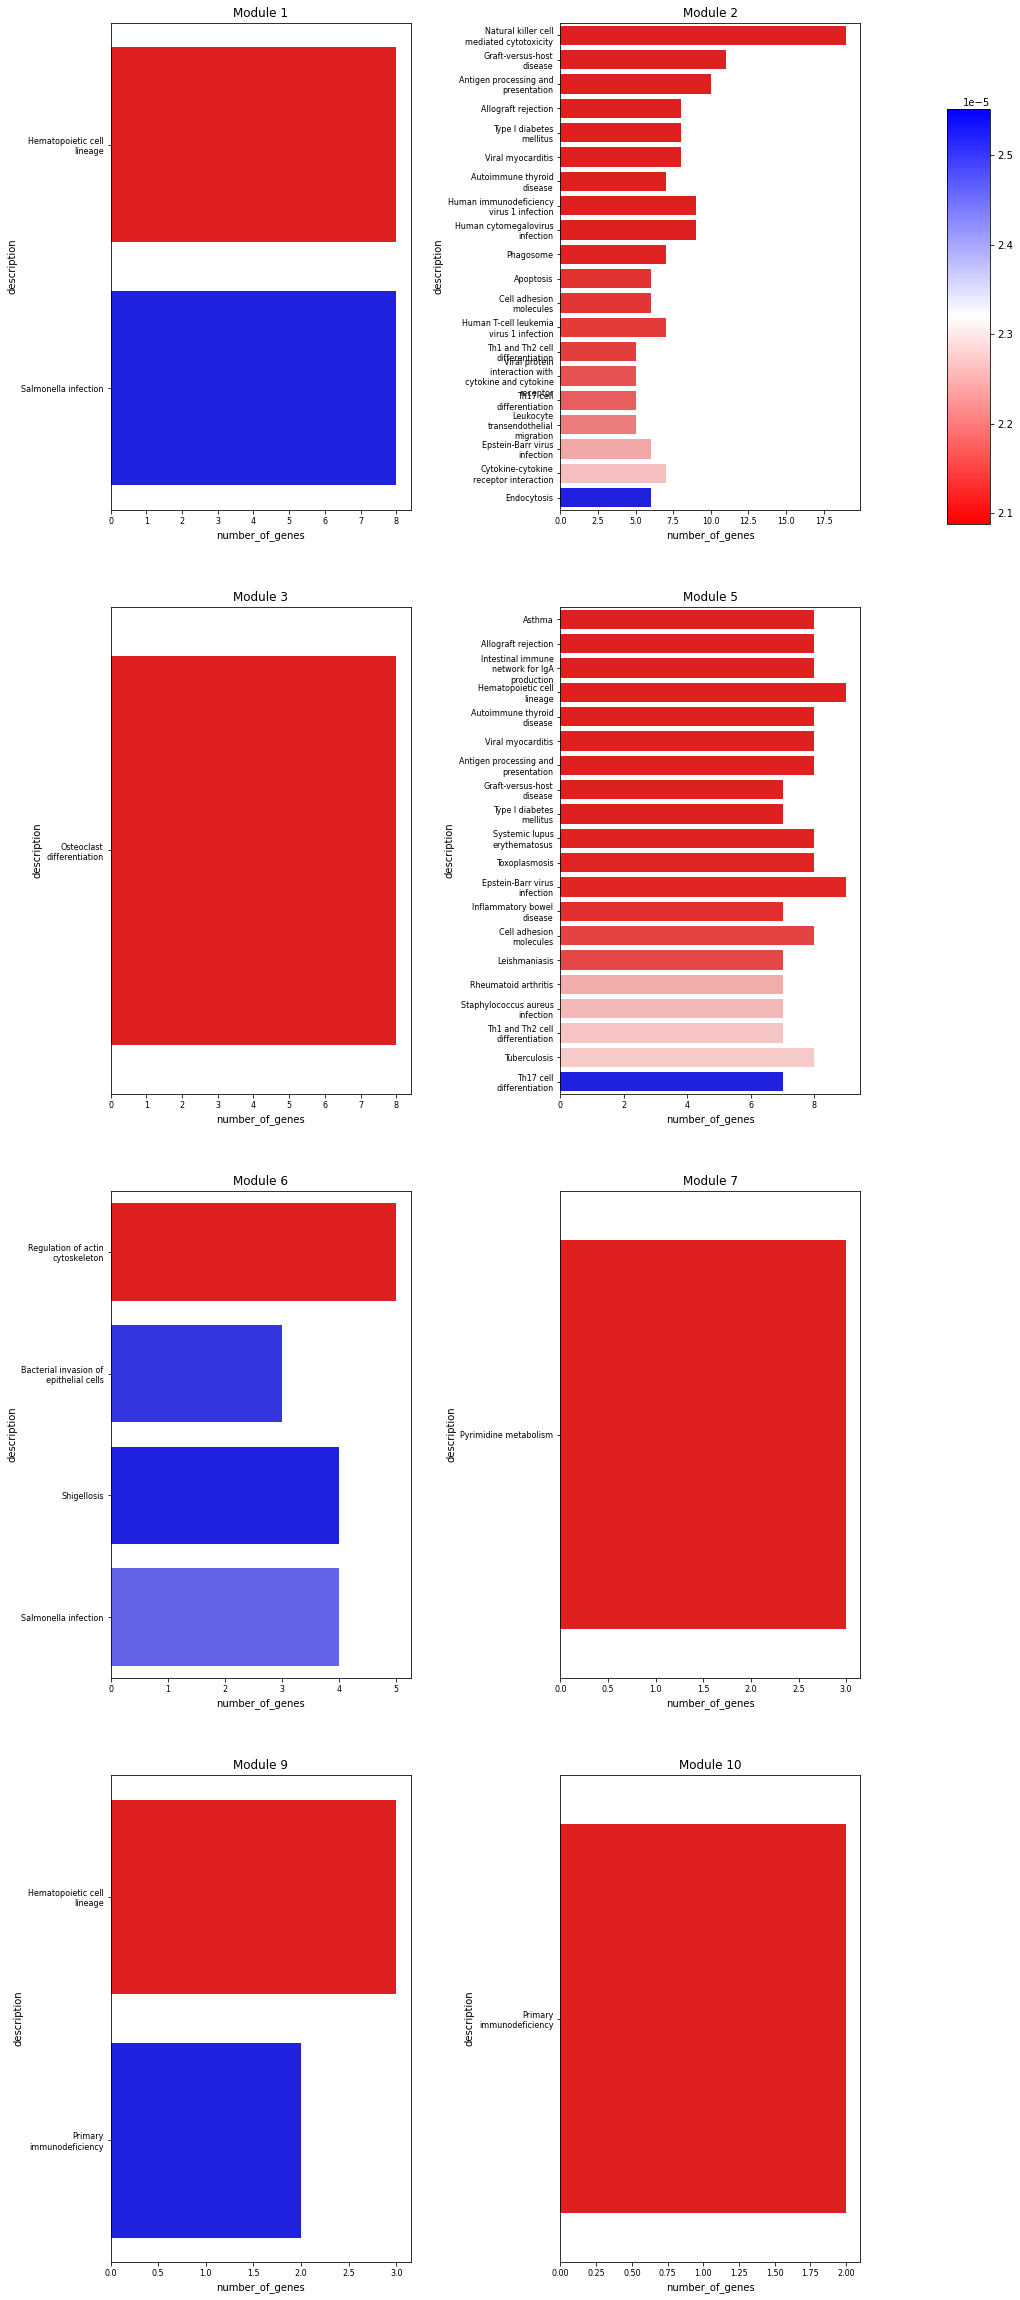

In [11]:
# Usage example:
selected_module = list(modules)#[0:2]  # Change the index [0] to the desired module's index

plotter = ModulePlotter(selected_module)

print('\033[1m\033[4mGO Process:\033[0m')
plotter.create_plots("Process")
print('\033[1m\033[4mGO Function:\033[0m')
plotter.create_plots("Function")
print('\033[1m\033[4mDiseases:\033[0m')
plotter.create_plots("DISEASES")
print('\033[1m\033[4mKEGG pathways:\033[0m')
plotter.create_plots("KEGG")


## Getting protein-protein interaction networks from your genes

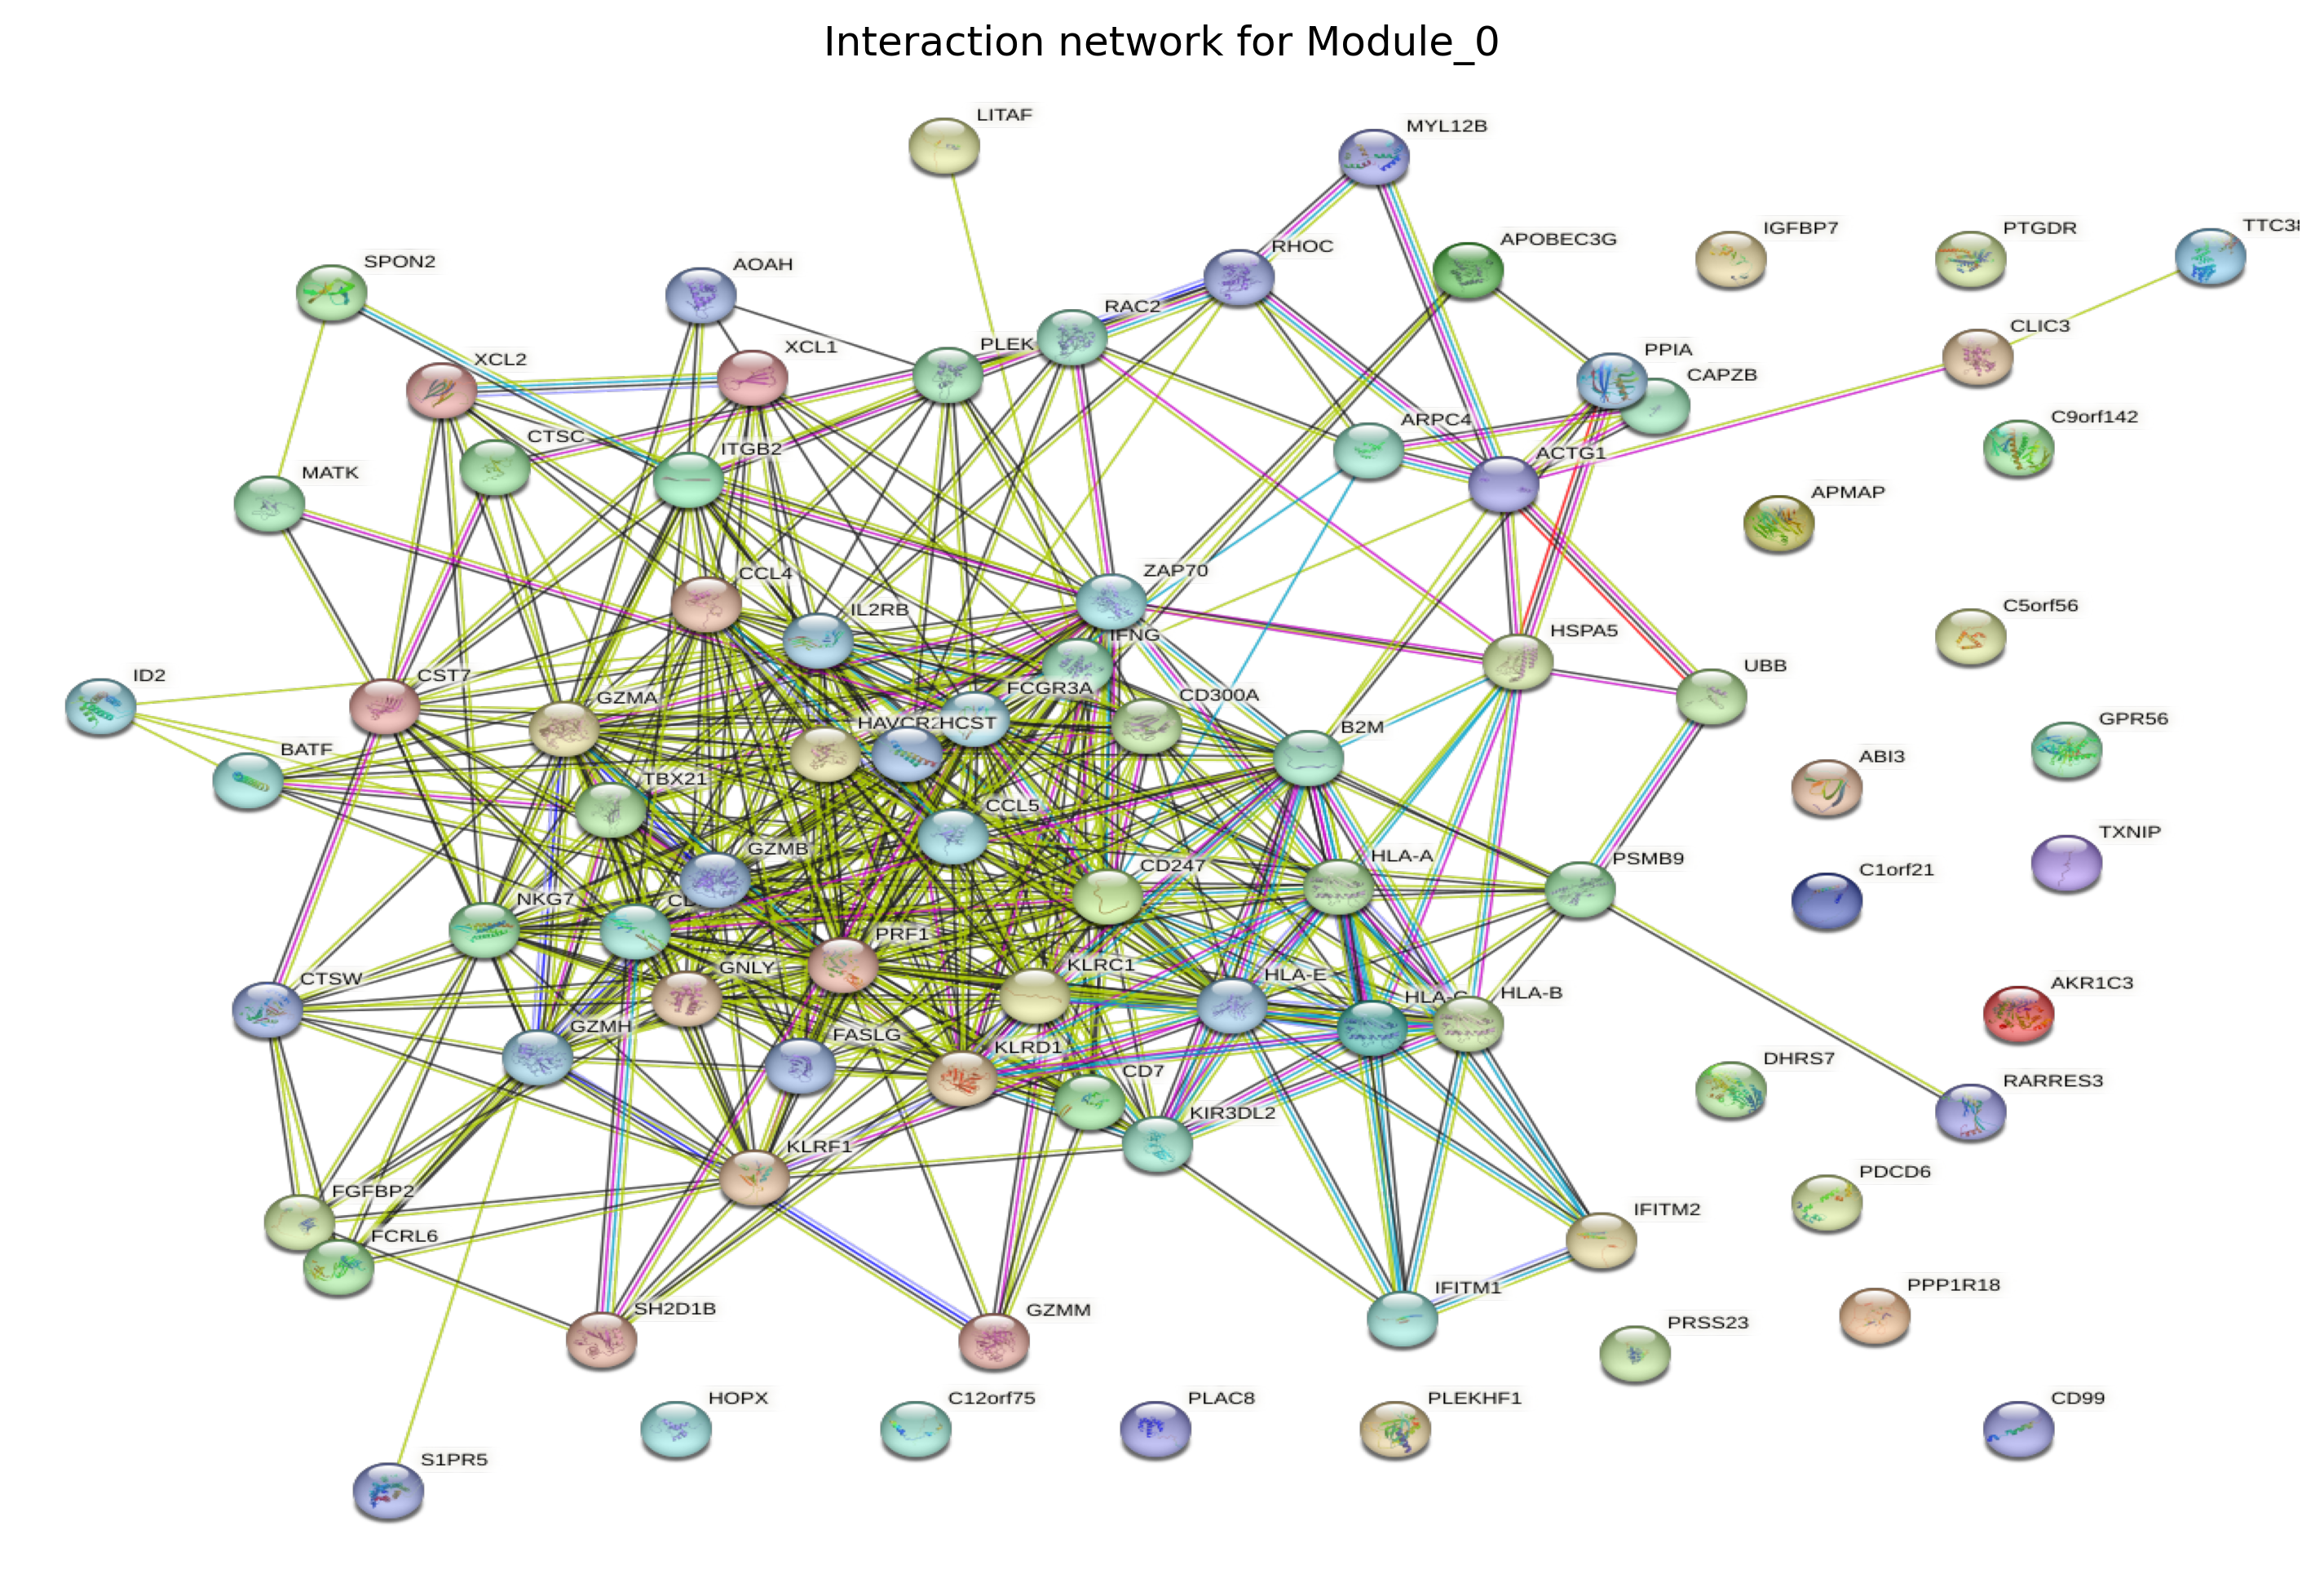

Saving interaction network to Module_0_network.png


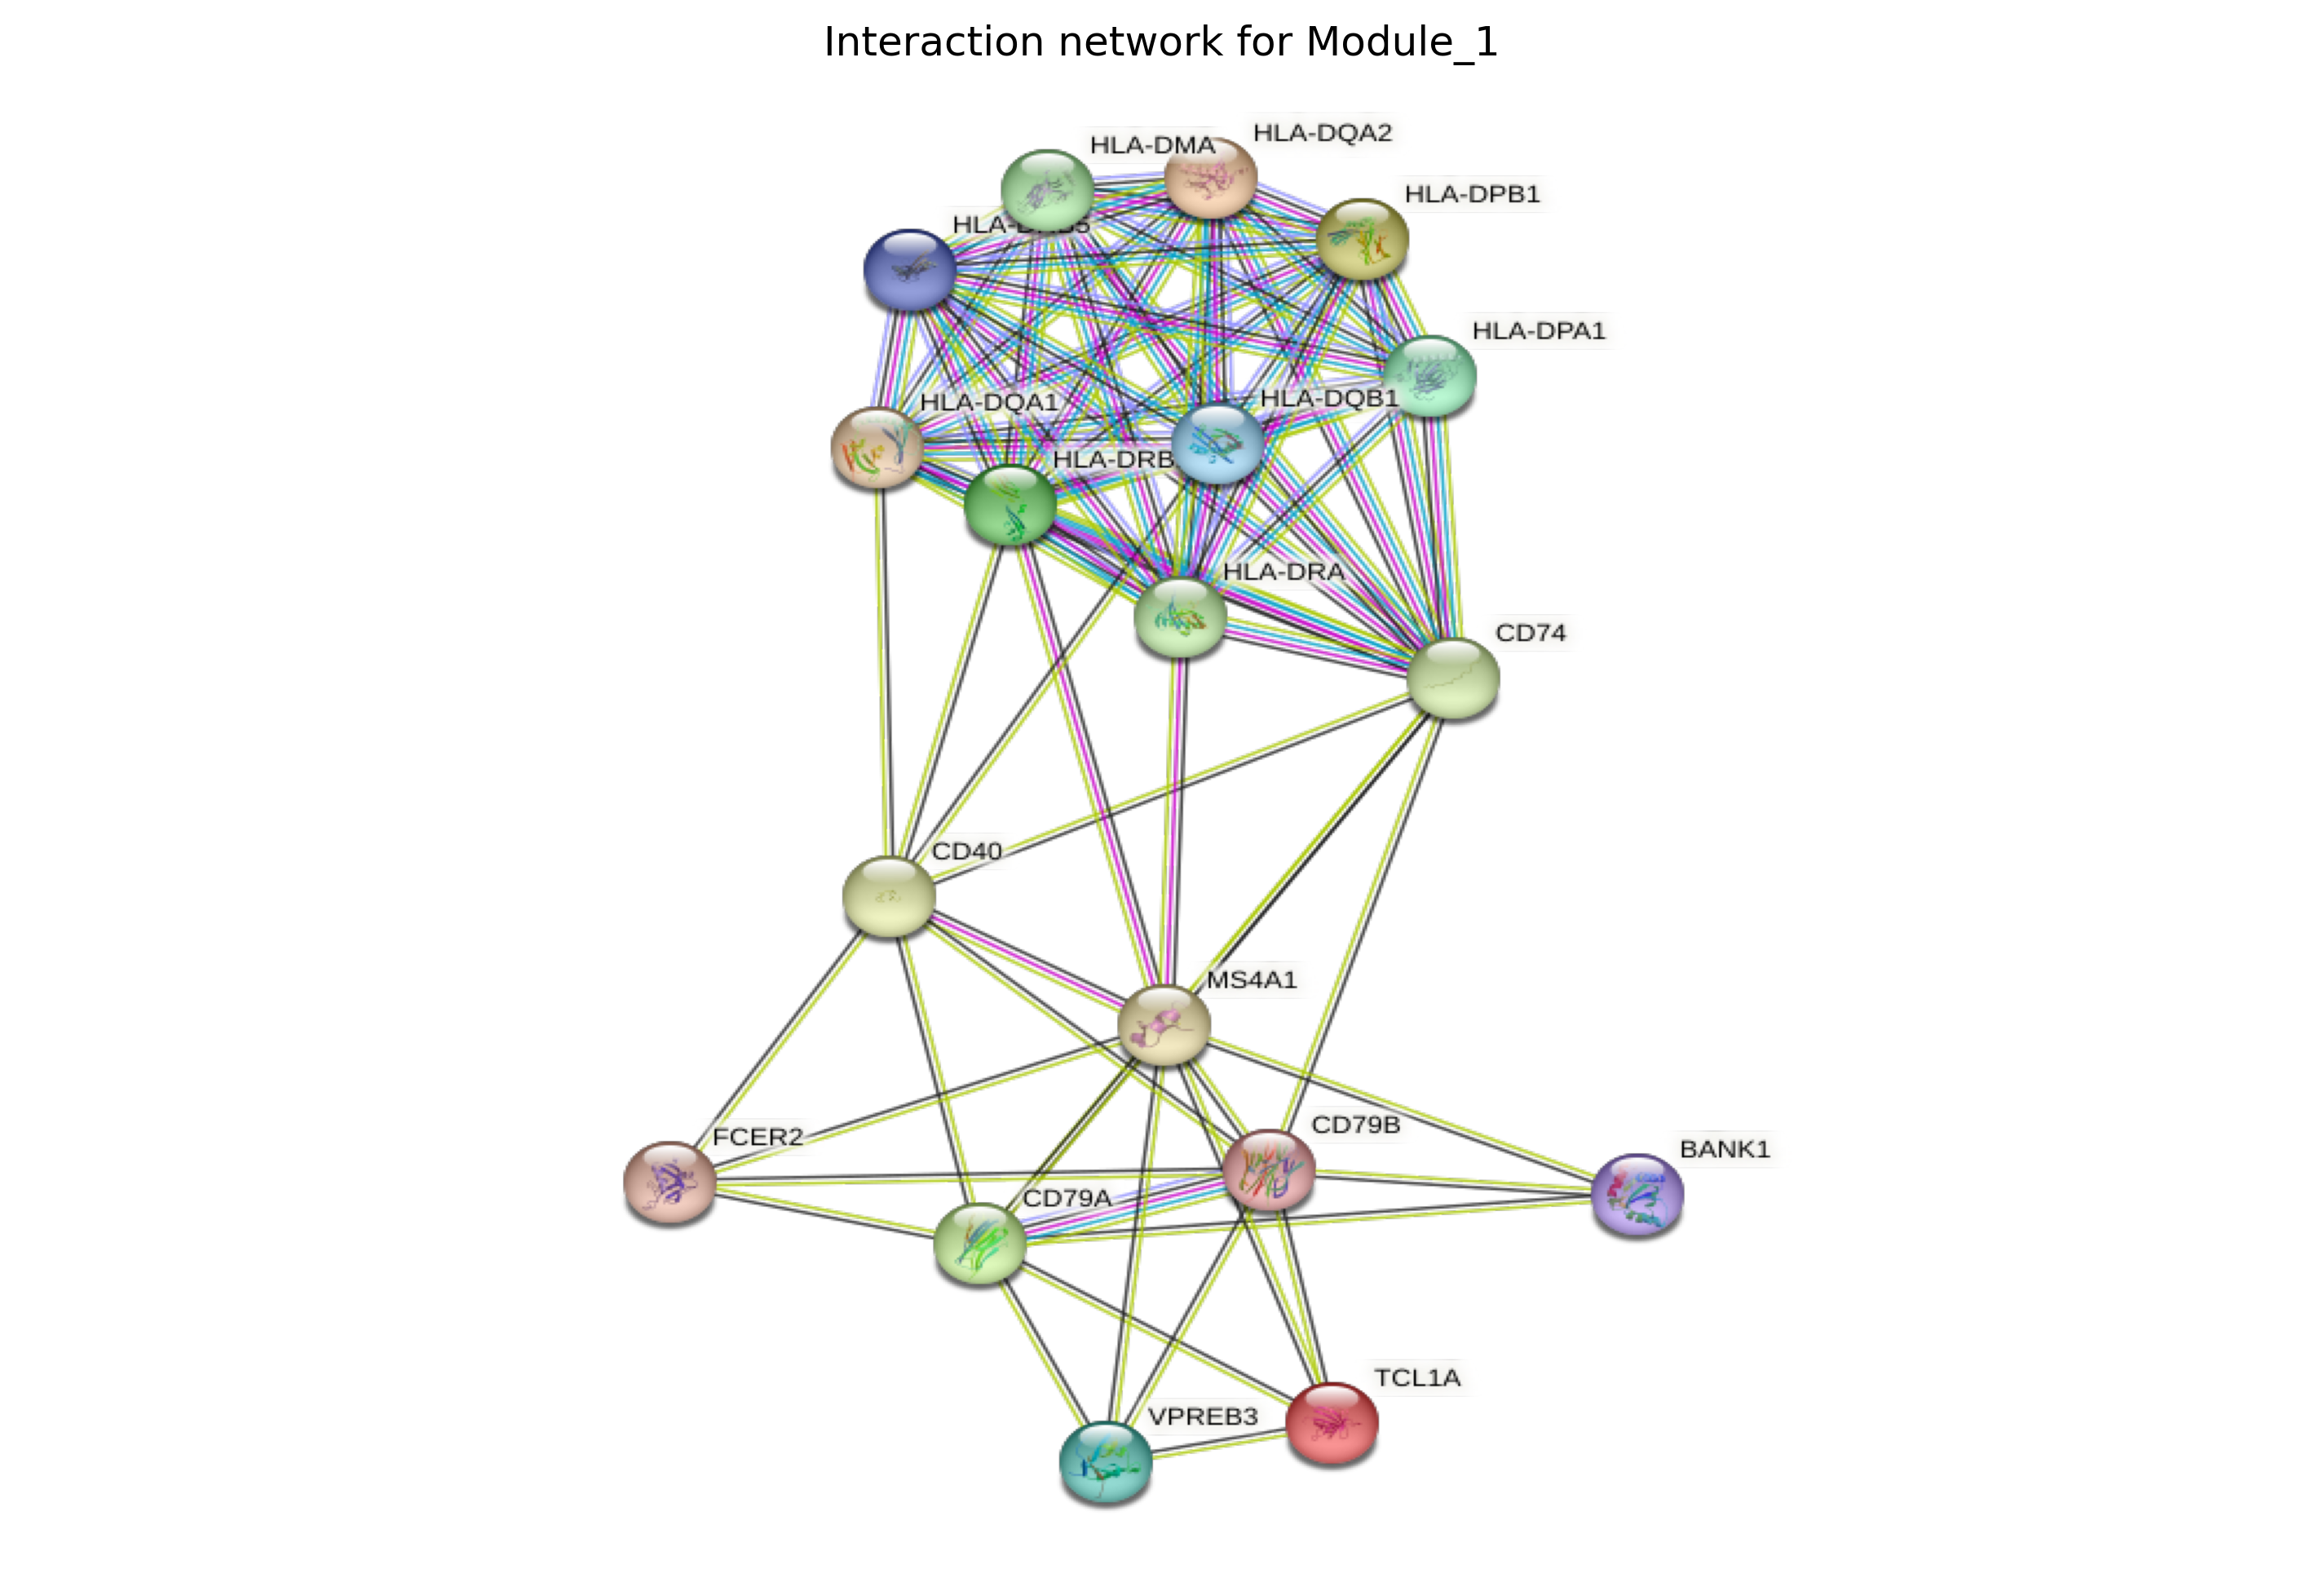

Saving interaction network to Module_1_network.png


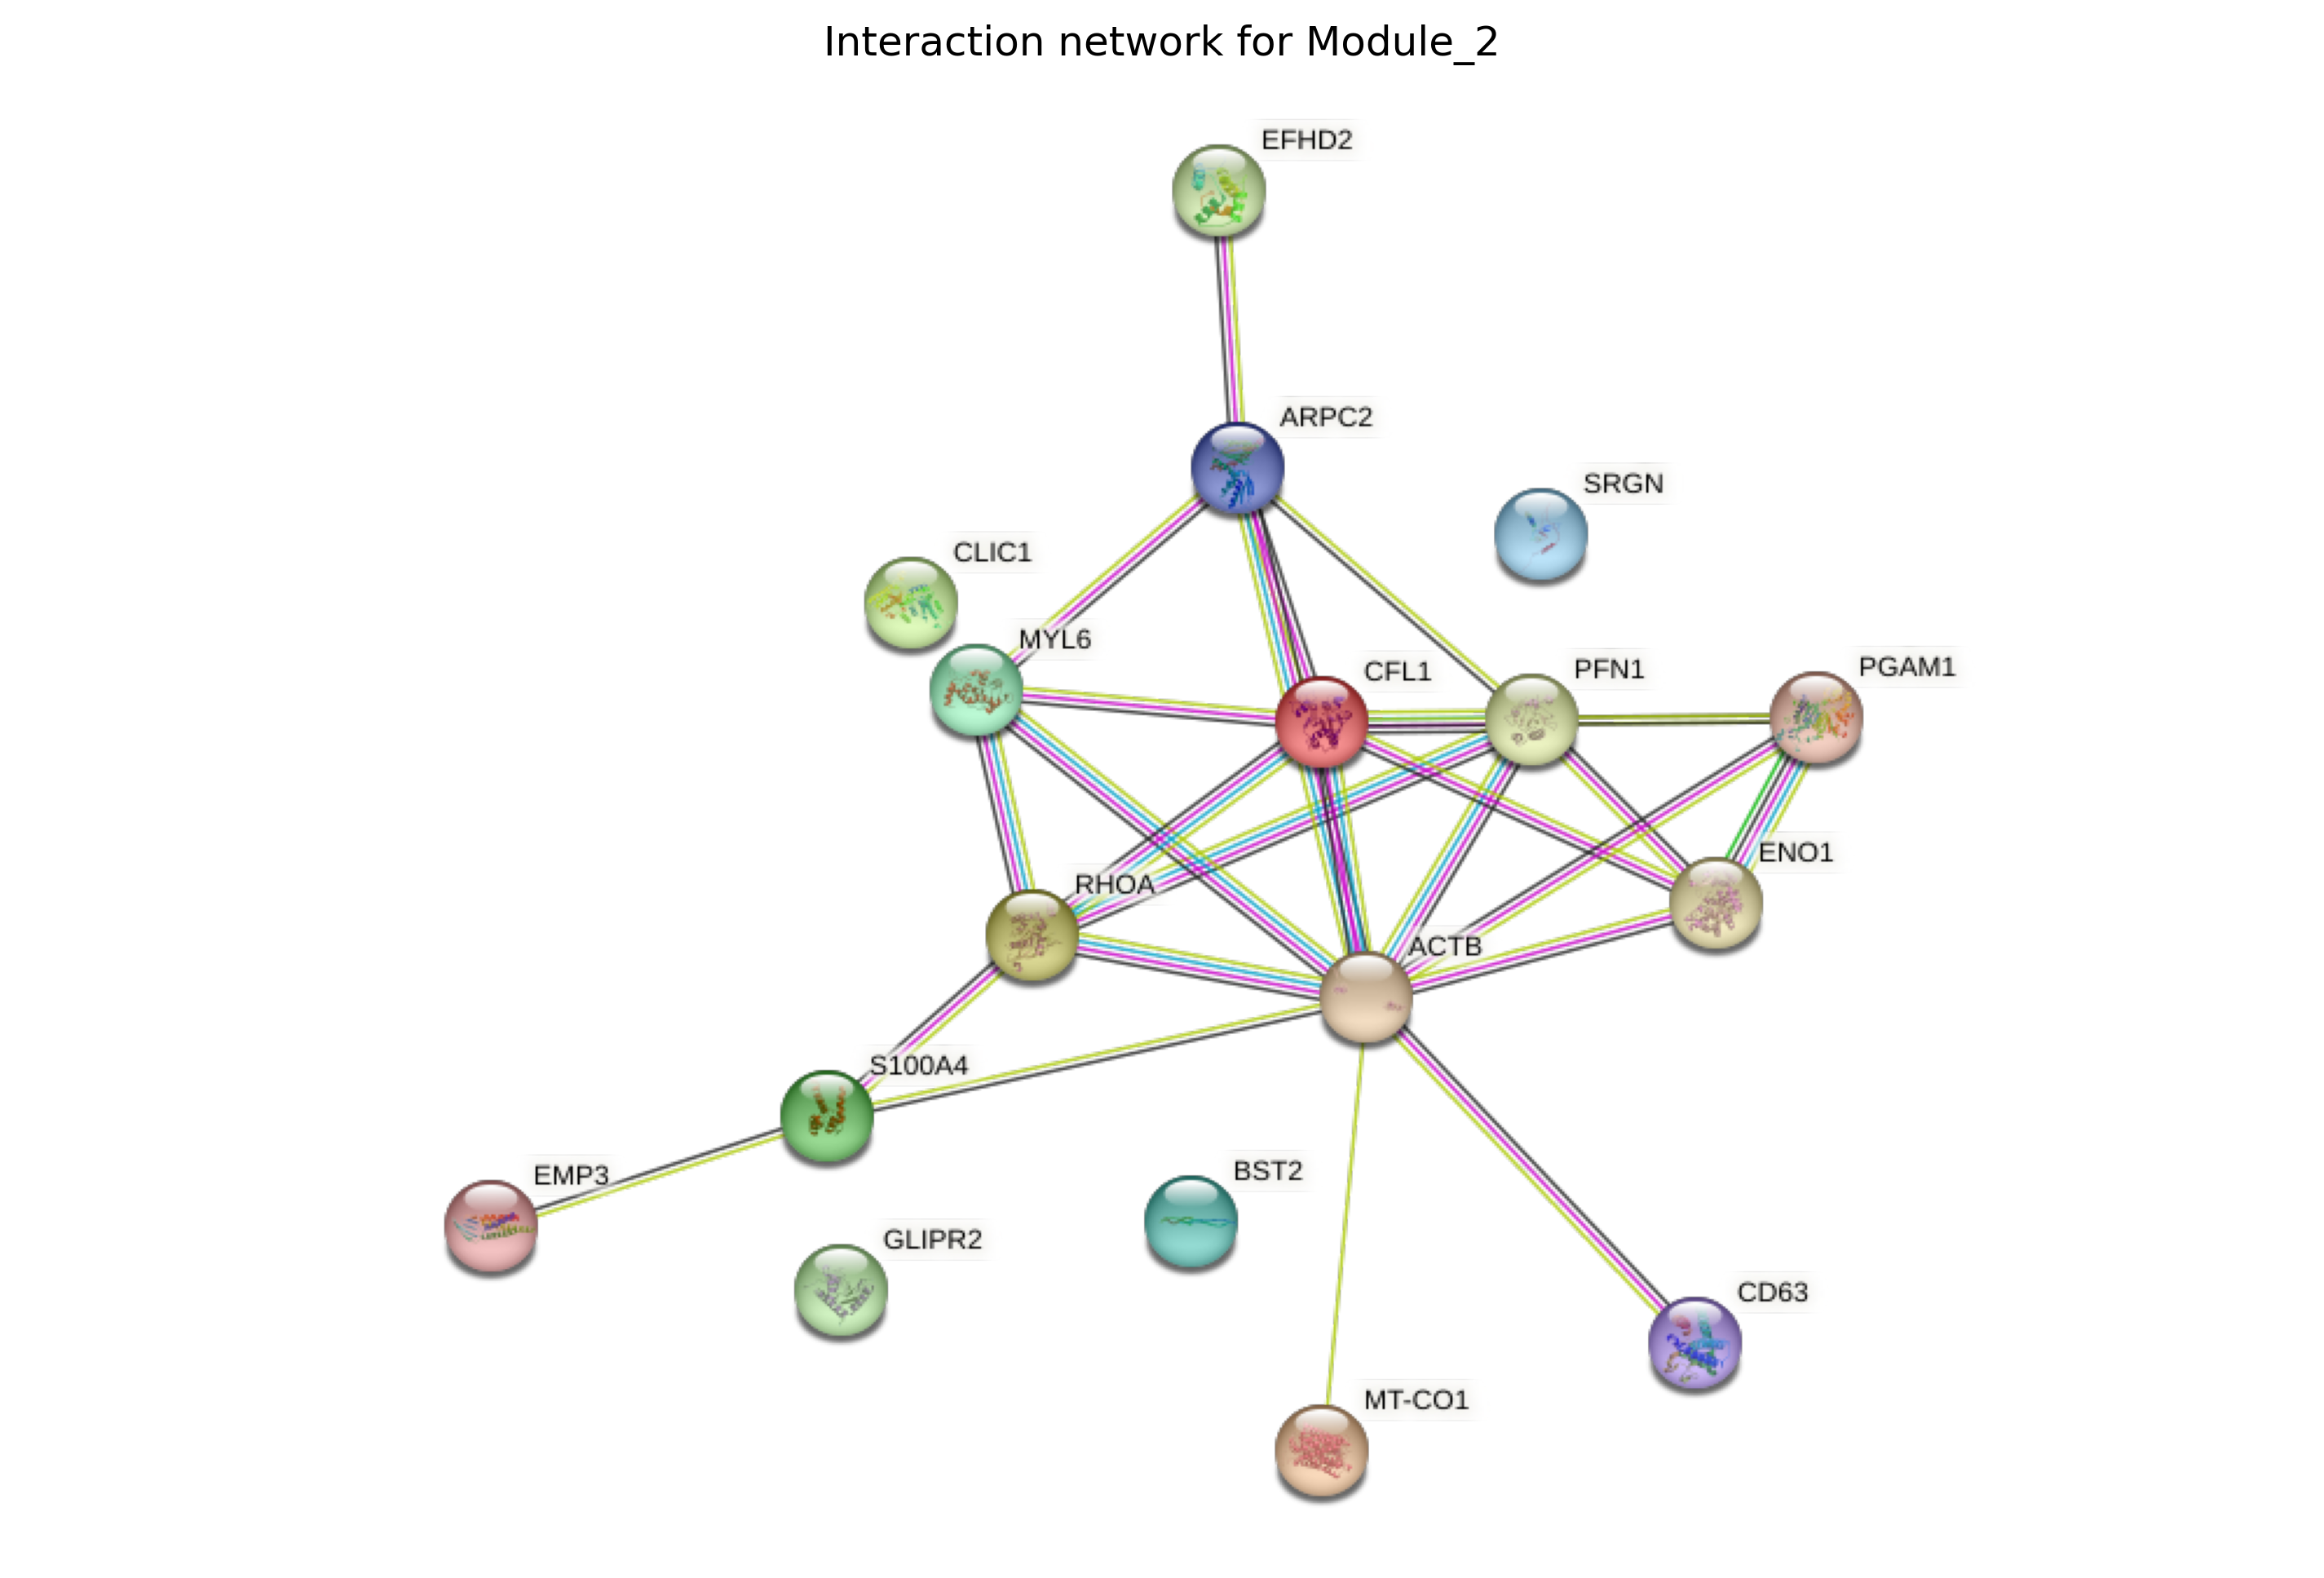

Saving interaction network to Module_2_network.png


In [12]:
import io
from time import sleep

string_api_url = "https://version-11-5.string-db.org/api"
output_format = "image"
method = "network"

selected_modules = [modules[1], modules[4], modules[5]]  # Modify the indices as needed, e.g. list(modules) for all.

for module_index, module_genes in enumerate(selected_modules):
    my_genes = module_genes
    gene_identifiers = '%0d'.join(my_genes)

    ##
    ## Construct URL
    ##

    request_url = "/".join([string_api_url, output_format, method])

    ## For each gene, call STRING
    num_genes = len(my_genes)

    params = {
        "identifiers": gene_identifiers,
        "species": 9606, # species NCBI identifier 
        "add_white_nodes": 15 - num_genes, # comment out for no proteins outside your query
        "network_flavor": "evidence", # "confidence" to show confidence links
        "show_query_node_labels": 1, #0 to hide labels
        "caller_identity": "www.awesome_app.org"
    }

    ##
    ## Call STRING
    ##

    response = requests.post(request_url, data=params)

    if response.ok:
        ##
        ## Plot the network
        ##

        plt.figure(figsize=(12, 8), dpi=300)  # Adjust figsize and dpi values as needed
        image_stream = io.BytesIO(response.content)
        plt.imshow(plt.imread(image_stream), aspect='auto')
        module_name = f"Module_{module_index}"
        plt.title("Interaction network for %s" % module_name)
        plt.axis('off')
        plt.show()

    else:
        print("Error retrieving network for module: %s" % module_index)
        print(response.content)

    # Generate the filename based on the module index and name
    module_name = f"Module_{module_index}"
    file_name = f"{module_name}_network.png"
    print("Saving interaction network to %s" % file_name)

    with open(file_name, 'wb') as fh:
        fh.write(response.content)

    sleep(1)
